# Trabalho de casa 01: Método dos vizinhos mais próximos ($k$-NN)

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'.

## Exercícios computacionais

**Exercício 1.** O código abaixo carrega o dataset MNIST, que consiste em imagens de dígitos entre $0$ e $9$. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 5) e reporte a acurácia para cada valor de $k$. Lembre que a acurácia é o percentual de amostras classificadas corretamente. Notavelmente, as entradas do MNIST tem dimensão relativamente alta (64). Plote uma imagem com a variância amostral dos pixels das imagens e comente. Também mostre as imagens classificadas de maneira errônea e comente.

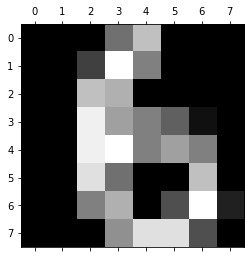

In [80]:
from dataclasses import dataclass

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.datasets import load_digits, make_moons
from sklearn.model_selection import train_test_split

SEED = 42
np.random.seed(SEED)

@dataclass
class Dataset:
    features_train: np.ndarray 
    features_test: np.ndarray  
    labels_train: np.ndarray   
    labels_test: np.ndarray

# Import dataset and separate train/test subsets
mnist = Dataset(*train_test_split(
    *load_digits(return_X_y=True),
    random_state=SEED,
))

# Notice that, in the MNIST dataset, the images are already flattened, i.e., are
# represented as 64-dimensional vectors, not as 8 by 8 matrices.

# To plot one of them, you should reshape it back into (8, 8)
plt.matshow(mnist.features_test[0].reshape(8, 8))
plt.gray()
plt.show()

Vamos estruturar nosso kNN:

In [81]:
# euclidean distance function
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

# kNN function
def knn(features_train, labels_train, features_test, k):
    pred = []
    for test_sample in features_test:
        distances = []
        for train_sample, train_label in zip(features_train, labels_train):
            distances.append((euclidean_distance(test_sample, train_sample), train_label))
        distances.sort()
        pred.append(np.argmax(np.bincount([label for _, label in distances[:k]])))
    return pred

# accuracy function
def accuracy(predictions, labels_test):
    return np.sum(predictions == labels_test) / len(labels_test)

Agora testaremos a acurácia para valores de k de 1 a 5:

In [82]:
# testing kNN with k from 1 to 5
for k in range(1,6):
    predictions = knn(mnist.features_train, mnist.labels_train, mnist.features_test, k)
    print(f"Acurácia com k = {k}: {accuracy(predictions, mnist.labels_test)}")

Acurácia com k = 1: 0.9822222222222222
Acurácia com k = 2: 0.9844444444444445
Acurácia com k = 3: 0.9866666666666667
Acurácia com k = 4: 0.9866666666666667
Acurácia com k = 5: 0.9933333333333333


Plotaremos a variância amostral de cada pixel em uma imagem. Para referência, ao seu lado colocaremos a imagem de um dígito qualquer (para visualizar melhor):

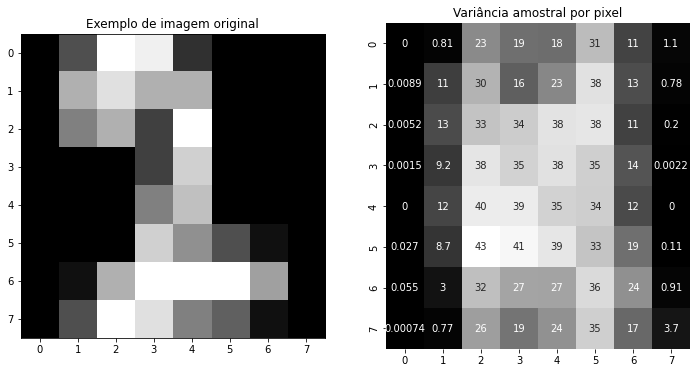

In [84]:
import seaborn as sns

def plot_variance_image(features, image_index):
    plt.figure(figsize = (12,6))
    # original
    plt.subplot(1,2,1)
    plt.imshow(features[image_index].reshape(8, 8))
    plt.title("Exemplo de imagem original")
    # variance
    plt.subplot(1,2,2)
    sns.heatmap(np.var(features, axis=0).reshape(8, 8), annot=True, cmap = 'gray', cbar = False)
    plt.title("Variância amostral por pixel")

plot_variance_image(mnist.features_train, 1)


Note que o resultado obtido é bem razoável, já que há maior variância nos pixels em que há tendência de mudança (isto é, um pixel central provavelmente será branco se tivermos um 1, porém preto se tivermos um 0), enquanto pixels dos cantos têm pouca variância, já que em geral são pretos (pois raramente existe uma parte do número ali). O primeiro pixel, no canto superior direito, por exemplo, tem variância amostral 0 - isto é, não varia, e pela imagem de exemplo podemos ver que ele é sempre preto.

Abaixo faremos, por fim, a plotagem das imagens que foram preditas incorretamente. Arbitrariamente faremos para k=5, pois foi onde tivemos maior acurácia.

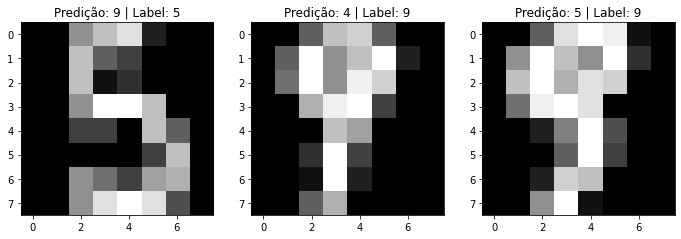

In [90]:
# getting wrong pred index
wrong_pred = []
pred = knn(mnist.features_train, mnist.labels_train, mnist.features_test, 5)
for index in range(len(pred)):
    if pred[index] != mnist.labels_test[index]:
        wrong_pred.append(index)

# plotting wrong predictions
plt.figure(figsize = (20,10))
for i in range(0, len(wrong_pred)):
    plt.subplot(1, 5, i+1)
    plt.imshow(mnist.features_test[wrong_pred[i]].reshape(8, 8))
    plt.title(f"Predição: {pred[wrong_pred[i]]} | Label: {mnist.labels_test[wrong_pred[i]]}")

É interessante observar que os dígitos em que tivemos predições erradas são, em geral, imagens de difícil interpretação até para o olho humano - isto é, são mais confusos e diferentes das outras imagens semelhantes. A segunda, por exemplo, tem label 9, mas é certamente mais esquisito e talvez não fosse classificado como um 9 mesmo por humanos.

**Exercício 02.** O código abaixo carrega o dataset "two moons", que consiste de amostras bidimensionais divididas em duas classes. Teste o $k$-NN com distância euclidiana para classificação do conjunto de teste. Use valores de $k$ diferentes (e.g., de 1 a 10). Plote a superfície de decisão para cada valor de $k$. Como $k$ influencia na suavidade dessas superfícies?

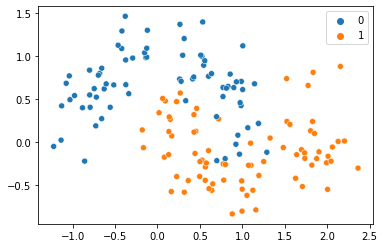

In [96]:
# Import dataset and separate train/test subsets
moon = Dataset(*train_test_split(
    *make_moons(n_samples=200, shuffle=True, noise=0.25, random_state=SEED),
    random_state=SEED,
))

# Let's also plot the moon dataset, for you to take a look at it.
sns.scatterplot(
    x=moon.features_train[:, 0],
    y=moon.features_train[:, 1],
    hue=moon.labels_train,
)
plt.show()

Utilizaremos o kNN para esse conjunto de dados, checando a acurácia para cada k de 1 a 10:

In [97]:
# kNN accuracy at moon dataset
for k in range(1,11):
    predictions = knn(moon.features_train, moon.labels_train, moon.features_test, k)
    print(f"Acurácia com k = {k}: {accuracy(predictions, moon.labels_test)}")

Acurácia com k = 1: 0.94
Acurácia com k = 2: 0.92
Acurácia com k = 3: 0.92
Acurácia com k = 4: 0.92
Acurácia com k = 5: 0.92
Acurácia com k = 6: 0.9
Acurácia com k = 7: 0.94
Acurácia com k = 8: 0.92
Acurácia com k = 9: 0.94
Acurácia com k = 10: 0.94


Agora faremos a plotagem das decision boundaries. 

Note que, observando os resultados, é possível perceber que a princípio há um overfitting, isto é, a decisão se ajusta demais a cada dado (um exemplo claro é a "ilha" azul formada quando k=1, mostrando que, apesar de a área estar cheia de pontos laranjas, como só consideramos o vizinho mais próximo, pontos ali seriam preditos como azuis). Com o aumento do k (até um valor razoável), temos que a superfície se torna mais suave. Certamente crescer demais o valor de k tornaria a curva ruim novamente, já que ela deixaria de fazer sentido, e consideraria pontos distantes demais para a decisão.

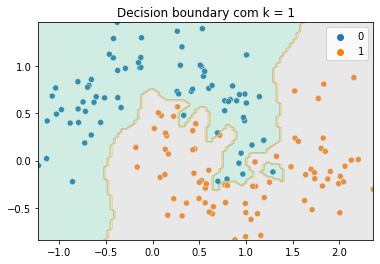

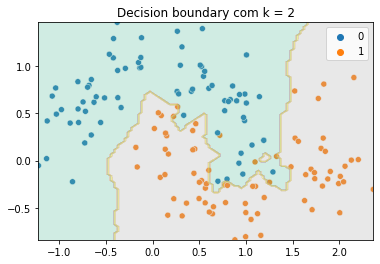

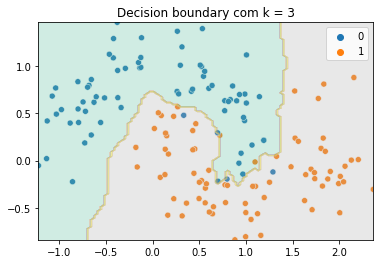

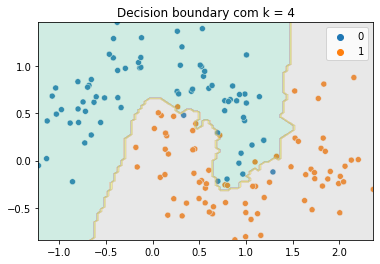

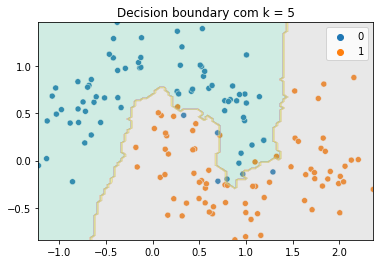

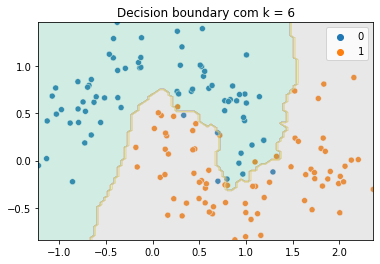

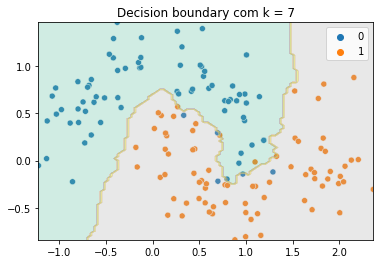

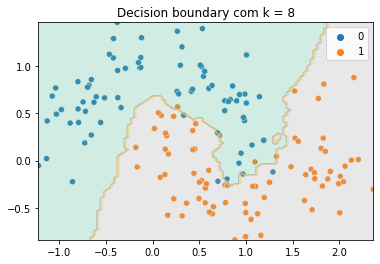

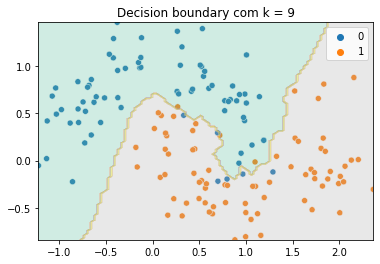

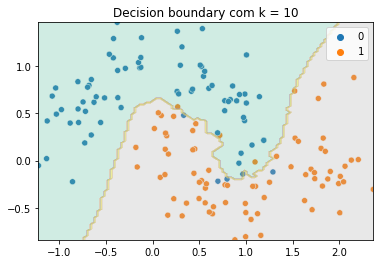

In [77]:
# decision boundary grid
xmax, xmin = moon.features_train[:, 0].max(), moon.features_train[:, 0].min()
ymax, ymin = moon.features_train[:, 1].max(), moon.features_train[:, 1].min()
x = np.linspace(xmin, xmax, 100) # makes it faster
y = np.linspace(ymin, ymax, 100) # makes it faster
xx, yy = np.meshgrid(x, y)
grid = np.c_[xx.ravel(), yy.ravel()]

# prediction
for k in range(1,11):
    predictions = knn(moon.features_train, moon.labels_train, grid, k)
    predictions = np.array(predictions).reshape(xx.shape)

    # decision boundary
    plt.figure(figsize = (6,4))
    sns.scatterplot(
        x=moon.features_train[:, 0],
        y=moon.features_train[:, 1],
        hue=moon.labels_train,
    )

    plt.contourf(xx, yy, predictions, cmap = 'Set2', alpha = 0.3)
    plt.title(f"Decision boundary com k = {k}")
    plt.show()

# Exercícios de "papel e caneta"

**Exercício 1.** Como mencionado na nota de aula, é comum *normalizar* os dados antes de utilizar algoritmos de ML. Seja $\mathbf{x} \in \mathcal{X}$ um ponto arbirtrário do nosso conjunto de dados (antes de normalização). Deixe também que $\mathcal{V}_k(\mathbf{x})$ seja o conjunto dos $k$ vizinhos mais próximos de $\mathbf{x}$ dentre nossas observações. É possível que $\mathcal{V}_k(\mathbf{x})$ mude caso normalizemos os dados? Prove.

Sim! Quando normalizamos os dados, os k-nearest neighbours podem mudar, e com isso o resultado final da predição pode ser alterado. Provaremos mostrando um exemplo em que $\mathcal{V}_k(\mathbf{x})$ muda ao normalizarmos os dados (utilizaremos a normalização mais comum, subtraindo a média e dividindo pelo desvio padrão, e um $k=3$):

Se tivermos, por exemplo, um conjunto de dados tal que:

| Dinheiro | Idade | Categoria |
| -------- | ----- | -----     |
| 1800     | 25    |1|
| 2000     | 30    |0|
| 500      | 35    |1|
| 1500     | 40    |0|
| 3000     | 45    |0|


Utilizaremos arbitrariamente o primeiro ponto para realizar o kNN, já que foi pedido que o ponto já fizesse parte do conjunto de dados. Sem normalizar, calculando as distâncias aproximadas do novo ponto até cada ponto já existente teremos:

|Dinheiro	|Idade	|Categoria| Distância calculada|
| --- | --- | --- | --- |
|1800| 25	  |  1| 0.000000 |
|2000| 30	  |  0| 200.062490 |
|500 | 35	  |  1| 1300.038461 |
|1500| 40	  |  0| 300.374766 |
|3000| 45     |  0| 1200.166655|

Assim, utilizando as 3 menores distâncias, teríamos num k-NN classificador que o ponto deve ser classificado como 0. Vamos repetir esse cálculo e calcular a distância novamente, porém normalizando os dados:

| Dinheiro   | Idade      | Categoria | Distância calculada       |
| ---------- | ----------| ----------| ----------|
| 0.044362   | -1.264911 | 1 |0.000000  |
| 0.266174   | -0.632456 | 0 |0.670224  |
| -1.397415  | 0.000000  | 1|1.917999  |
| -0.288355  | 0.632456  | 0|1.926318  |
| 1.375233   | 1.264911  | 0|2.858534  |

Dessa vez temos, utilizando os 3 vizinhos mais próximos, que o novo ponto será classificado como 1! Está provado, então, que  $\mathcal{V}_k(\mathbf{x})$ pode mudar quando normalizamos os dados!



**Exercício 2.** Suponha que estamos usando $k$-NN equipado com distância Mahalanobis $d_M$ (veja Eq. 3.5 das notas de aula). Suponha ainda que $\Sigma$ é a matrix de covariância real dos dados (i.e., do vetor aleatório $\mathbf{x} \sim \mathbb{P}_\mathbf{x}$), ao invés de uma estimativa baseada em amostras. Existe uma transformação $g$ tal que $d_M(a, b) = \|g(a) - g(b) \|_2$? Mostre a transformação e derive a matriz de covariância de $z = g(\mathbf{x})$. 

Vamos partir da distância Mahalanobis e queremos chegar à distância euclidianda, mostrando que existe uma transformação $g(x)$ que torna isso possível. Vamos lembrar que a distância Mahalanobis é:

$$d_M =  \sqrt{(x-y)^T\Sigma^{-1}(x-y)}$$

Assumindo, conforme discutido em aula, que $\Sigma$, a matriz de correlação, é definida positiva, podemos aplicar a decomposição espectral e escrevê-la como $\Sigma = Q \lambda Q^T$, onde $Q$ é a matriz de autovetores e $\lambda$ é a matriz de autovalores. Assim, partiremos para a manipulação algébrica:

$$ \sqrt{(x-y)^T(Q \lambda Q^T)^{-1}(x-y)}$$
$$\sqrt{(x-y)^T(Q \sqrt{\lambda}\sqrt{\lambda} Q^T)^{-1}(x-y)}$$
$$\sqrt{(x-y)^T((\sqrt{\lambda}Q^T)^{-1}(Q\sqrt{\lambda})  )^{-1}(x-y)}$$
$$\sqrt{(x-y)^TQ\sqrt{\lambda}^{-1}\sqrt{\lambda}^{-1}Q^T (x-y)}$$
$$\sqrt{(Q\sqrt{\lambda}^{-1})^T(x-y)\sqrt{\lambda}^{-1}Q^T (x-y)}$$
$$\sqrt{((\sqrt{\lambda}^{-1}Q^T )(x-y))^T\sqrt{\lambda}^{-1}Q^T (x-y)}$$

Agora podemos aplicar a distributiva:

$$\sqrt{(\sqrt{\lambda}^{-1}Q^T x - \sqrt{\lambda}^{-1}Q^T y )^T(\sqrt{\lambda}^{-1}Q^T x - \sqrt{\lambda}^{-1}Q^T y )}$$

Aqui obtivemos, como era nosso objetivo, algo no formato da distância euclidiana!

$$||\sqrt{\lambda}^{-1}Q^T x - \sqrt{\lambda}^{-1}Q^T y  ||_2$$

Isto é, temos $||g(x) - g(y)  ||_2$. Nesse caso, podemos definir a transformação $g(x) = {\sqrt \lambda}^{-1} Q^T x$, onde $\lambda$ é a matriz de autovalores e $Q$ de autovetores (de $\Sigma$, matriz de correlação).

Desejamos, por fim, encontrar a matriz de covariância de $g(x)$. Para isso, a colocaremos na generalização do conceito da matriz de covariância: $E[(Z-E[Z])(Z-E[Z])^T]$. Temos:


$$E[(g(x)-E[g(x)])(g(x)-E[g(x)])^T]$$
$$E[( {\sqrt \lambda}^{-1} Q^T x- {\sqrt \lambda}^{-1} Q^T E[x])( {\sqrt \lambda}^{-1} Q^T x- {\sqrt \lambda}^{-1} Q^T E[x])^T]$$
$$E[( {\sqrt \lambda}^{-1} Q^T x- {\sqrt \lambda}^{-1} Q^T E[x])( x^T Q{\sqrt \lambda}^{-1}- E[x]^T Q{\sqrt \lambda}^{-1}  )]$$

Vamos, novamente, aplicar a distributiva:

$$ E[ {\sqrt \lambda}^{-1} Q^T x x^T Q{\sqrt \lambda}^{-1} - {\sqrt \lambda}^{-1} Q^T x  E[x]^T Q{\sqrt \lambda}^{-1} - {\sqrt \lambda}^{-1} Q^T E[x] x^T Q{\sqrt \lambda}^{-1} + {\sqrt \lambda}^{-1} Q^T E[x]E[x]^T Q{\sqrt \lambda}^{-1}] $$
$${\sqrt \lambda}^{-1} Q^T  E[xx^T -xE[x^T]-E[x]x^T+ E[x]E[x]^T] Q{\sqrt \lambda}^{-1}$$
$${\sqrt \lambda}^{-1} Q^T  E[(x-E[x]  )   (  x-E[x])^T] Q{\sqrt \lambda}^{-1}$$

Sabemos que, conforme definido inicialmente, $E[(x-E[x]  )   (  x-E[x])^T]$ é a generalização da matriz de covariância de $x$. Então:

$${\sqrt \lambda}^{-1} Q^T  \Sigma Q{\sqrt \lambda}^{-1}$$

Como foi dito anteriormente, sabemos que pode-se aplicar a decomposição espectral em $\Sigma$, então:

$${\sqrt \lambda}^{-1} Q^T  Q \lambda Q^T Q{\sqrt \lambda}^{-1}$$
$${\sqrt \lambda}^{-1} Q^T  Q \sqrt{\lambda} \sqrt{\lambda} Q^T Q{\sqrt \lambda}^{-1}$$
$${\sqrt \lambda}^{-1} I \sqrt{\lambda} \sqrt{\lambda} I{\sqrt \lambda}^{-1}$$
$${\sqrt \lambda}^{-1}  \sqrt{\lambda} \sqrt{\lambda} {\sqrt \lambda}^{-1}$$
$$ I$$

Assim, derivamos a matriz de covariância para a transformação $g(x)$, obtendo a matriz identidade!

